# Nearest node function

Notebook that tests the nearest node function and the new distance functions.

## Import used modules

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import time
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download municipality GeoDataFrame

In [2]:
gdf = aup.gdf_from_db("mpos_2020", "marco")
m = ['01001']
mun_gdf = gpd.GeoDataFrame()
for mun in m:
    mun_gdf = mun_gdf.append(gdf.loc[gdf.CVEGEO == mun])
mun_gdf.head(1)

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0..."


## Download OSMnx

In [3]:
poly = mun_gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [4]:
G = ox.graph_from_bbox(n, s, e, w, network_type="all")

## Download DENUE GeoDataFrame

In [5]:
# Creates query to download nodes from the metropolitan area or capital
poly_wkt = mun_gdf.dissolve().geometry.to_wkt()[0]
query = f"SELECT * FROM denue.denue_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue = aup.gdf_from_query(query, geometry_col='geometry')
print(denue.shape)
denue.head(2)

(46054, 42)


,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry
0,6862345.0,AGROPECUARIA CHARCOS DE QUEZADA,AGROPECUARIA CHARCOS DE QUEZADA SOCIEDAD DE PR...,115119.0,Otros servicios relacionados con la agricultura,31 a 50 personas,AVENIDA,UNIVERSIDAD,CALLE,BENJAMÍN MÉNDEZ,...,0233,9.0,4492854000.0,MICHAEL.GALINDO@UGASA.COM.MX,None,Fijo,21.906992,-102.30981,2019-04,POINT (-102.30981 21.90699)
1,6905212.0,AGROPECUARIO LOS ALAMITOS,None,115119.0,Otros servicios relacionados con la agricultura,0 a 5 personas,CALLE,J. ENCARNACION PAYEN,CALLE,JARDINES ETERNOS,...,0322,18.0,4499960300.0,None,None,Fijo,21.889927,-102.31401,2019-11,POINT (-102.31401 21.88993)


## Testing the nearest node functions

In [6]:
start = time.time()
gdf_old = aup.find_nearest_old(G, denue, 'all')
end = time.time()
print(end - start)

/root/anaconda3/envs/geo_env/lib/python3.9/site-packages/osmnx/distance.py:426: UserWarning: The `get_nearest_nodes` function has been deprecated and will be removed in a future release. Use the more efficient `distance.nearest_nodes` instead.
  warnings.warn(msg)


2.0591320991516113


In [7]:
start = time.time()
gdf_new = aup.find_nearest(G, denue)
end = time.time()
print(end - start)

2.4247002601623535


In [8]:
gdf_new.head(2)

,id,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,nom_v_e_1,...,www,tipo_uni_eco,latitud,longitud,fecha_alta,geometry,x,y,nearest_all,osmid
0,6862345.0,AGROPECUARIA CHARCOS DE QUEZADA,AGROPECUARIA CHARCOS DE QUEZADA SOCIEDAD DE PR...,115119.0,Otros servicios relacionados con la agricultura,31 a 50 personas,AVENIDA,UNIVERSIDAD,CALLE,BENJAMÍN MÉNDEZ,...,None,Fijo,21.906992,-102.30981,2019-04,POINT (-102.30981 21.90699),-102.309807,21.906992,8553121190,8553121190
1,6905212.0,AGROPECUARIO LOS ALAMITOS,None,115119.0,Otros servicios relacionados con la agricultura,0 a 5 personas,CALLE,J. ENCARNACION PAYEN,CALLE,JARDINES ETERNOS,...,None,Fijo,21.889927,-102.31401,2019-11,POINT (-102.31401 21.88993),-102.314011,21.889927,842077439,842077439


## Testing new distance functions

In [9]:
amenity_name = 'farmacia'
col_dist = f'dist_{amenity_name}'

nodes, edges = ox.graph_to_gdfs(G)
denue_farm = gdf_new[(gdf_new['codigo_act']==464111)|(gdf_new['codigo_act']==464112)]

start = time.time()
gdf_dist = aup.calculate_distance_nearest_poi(denue_farm, nodes, G, 'farmacia', 'osmid')
end = time.time()
print(end - start)

11.119261026382446


<AxesSubplot:>

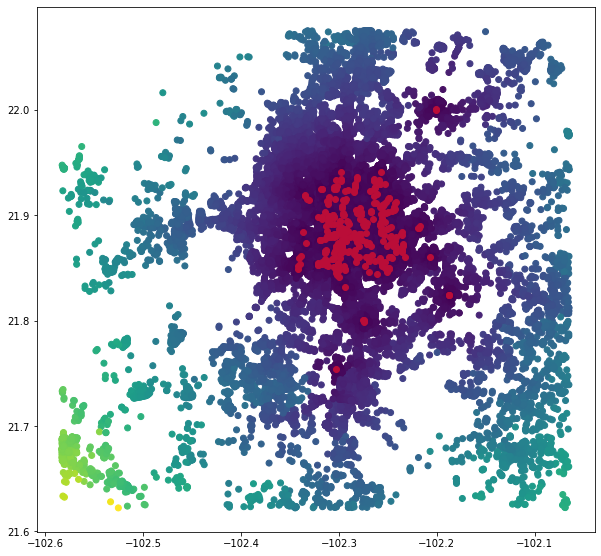

In [10]:
fig,ax = plt.subplots(figsize=(10,10))
denue_farm.plot(ax=ax, color='#ba0d38',zorder=1)
gdf_dist.plot(gdf_dist.dist_farmacia, ax=ax, zorder=-1)